## Clinical Data Preprocessing

This notebook loads the raw cohort, applies a structured preprocessing pipeline (load, split, impute and scale with a KNN imputer and a QuantileTransformer), and saves a clean, analysis-ready dataset.

In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import ClinicalDataLoader
from src.features import ClinicalPreprocessor
from src.visualization import plot_before_after_histogram

In [2]:
DATA_PATH = Path("../data/raw/dataset.xlsx")
OUT_PATH = Path("../data/processed/01_cleaned_advanced.csv")
FIG_DIR = Path("../figures")
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

loader = ClinicalDataLoader(DATA_PATH)
features, meta = loader.load_cohort(min_labs=10, max_missing=0.9)
df = pd.concat([meta, features], axis=1)

print(f"Loaded: {df.shape[0]} rows, {df.shape[1]} columns")

Loaded: 603 rows, 51 columns


In [3]:
preprocessor = ClinicalPreprocessor(n_neighbors=5, output_distribution="normal")
X_clean, X_pca = preprocessor.fit_transform(features)

output = meta.copy()
for c in X_clean.columns:
    output[c] = X_clean[c].values
output.to_csv(OUT_PATH, index=False)
print(f"Saved: {OUT_PATH}")

Saved: ..\data\processed\01_cleaned_advanced.csv


c:\Users\amitf\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (603). n_quantiles is set to n_samples.
  warnings.warn(


## Data Quality and Transformation Audit

This section examines data quality and the impact of the preprocessing pipeline. We visualize sparsity patterns, how the transformations change the marginal distributions, and the extent to which the underlying clinical correlations are preserved after imputation and scaling.

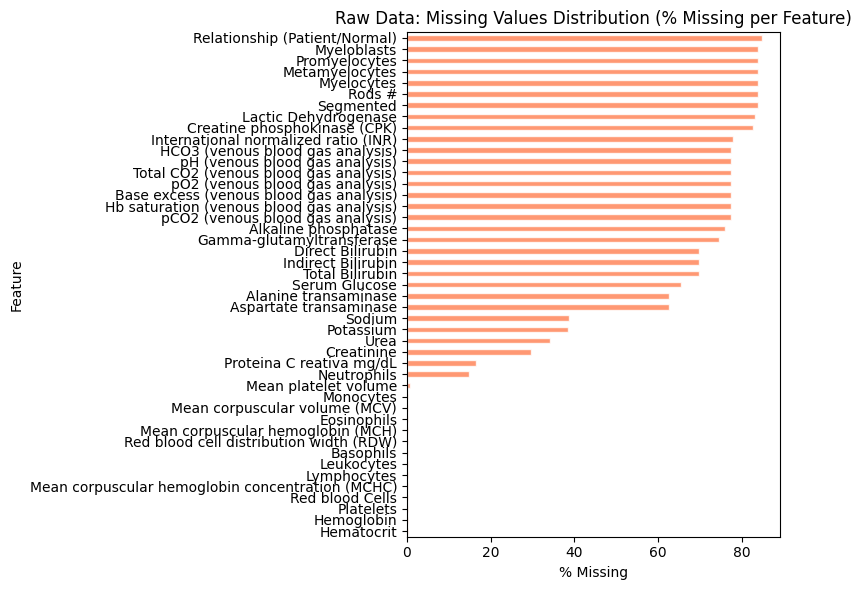

In [4]:
# 1. Missing Values Map
missing_pct = features.isna().mean() * 100
missing_pct = missing_pct.sort_values(ascending=True)
plt.figure(figsize=(8, 6))
missing_pct.plot(kind="barh", color="coral", alpha=0.8, edgecolor="white")
plt.title("Raw Data: Missing Values Distribution (% Missing per Feature)")
plt.xlabel("% Missing")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(FIG_DIR / "missing_values_map.png", dpi=300)
plt.show()

### Interpretation: Missing Values Map
This chart reports, for each feature, the percentage of missing observations. It allows us to quickly distinguish lab tests that are routinely measured from those that are rarely ordered. These patterns motivate our decision to drop variables with extreme missingness (for example, more than 90 percent missing) and to apply an imputation strategy for the remaining tests, since the raw data matrix contains many gaps.

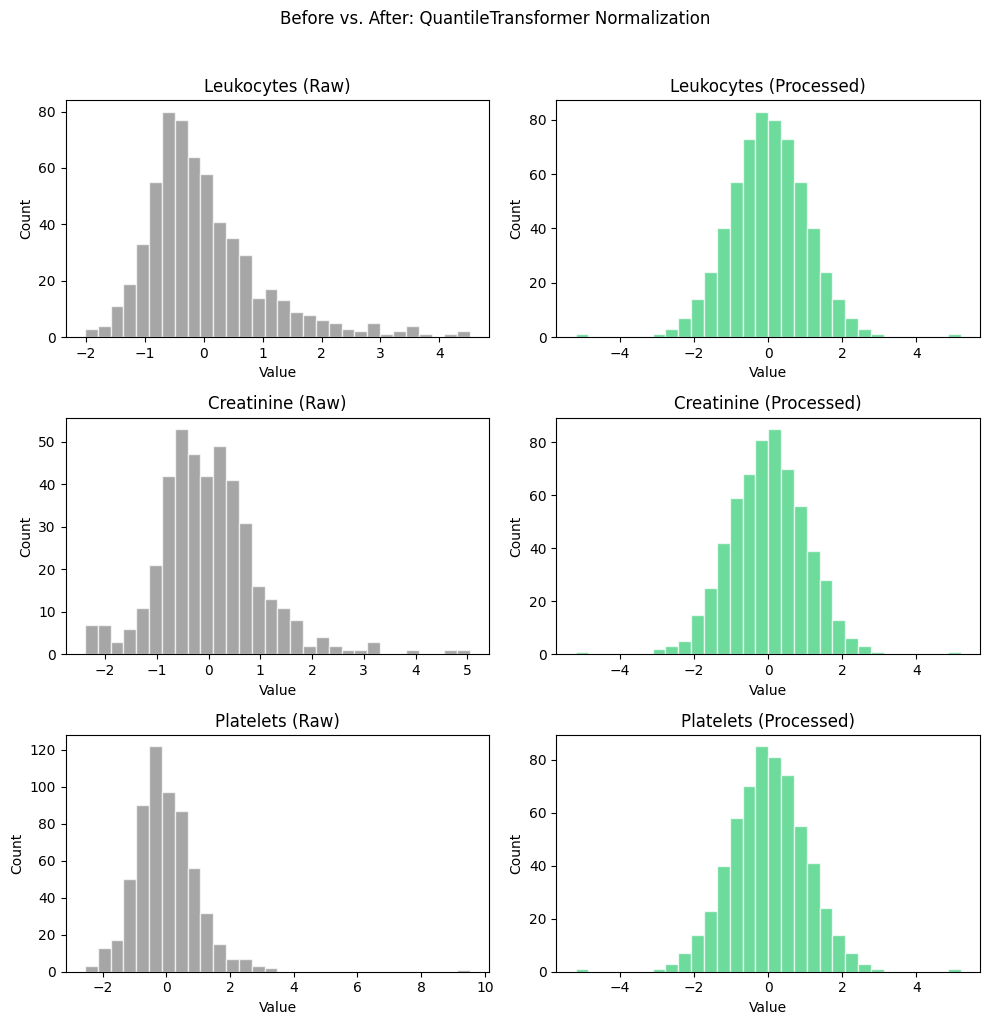

In [5]:
# 2. Before vs. After Distribution Grid (QuantileTransformer effect)
biomarkers = ["Leukocytes", "Creatinine", "Platelets"]
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i, feat in enumerate(biomarkers):
    if feat not in features.columns or feat not in X_clean.columns:
        continue
    axes[i, 0].hist(features[feat].dropna(), bins=30, color="gray", alpha=0.7, edgecolor="white")
    axes[i, 0].set_title(f"{feat} (Raw)")
    axes[i, 0].set_xlabel("Value")
    axes[i, 0].set_ylabel("Count")
    axes[i, 1].hist(X_clean[feat].dropna(), bins=30, color="#2ecc71", alpha=0.7, edgecolor="white")
    axes[i, 1].set_title(f"{feat} (Processed)")
    axes[i, 1].set_xlabel("Value")
    axes[i, 1].set_ylabel("Count")
plt.suptitle("Before vs. After: QuantileTransformer Normalization", fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(FIG_DIR / "before_after_grid.png", dpi=300)
plt.show()

### Interpretation: Before and After Distribution Grid
This grid focuses on three representative biomarkers (Leukocytes, Creatinine and Platelets) before and after preprocessing. The left column shows the raw distributions, which are typically skewed, heavy-tailed and dominated by outliers. The right column shows the same variables after application of the KNN imputer and QuantileTransformer, yielding distributions that are more symmetric, centered and statistically well behaved. This visual comparison illustrates how the preprocessing pipeline converts data that are challenging for linear methods into inputs that are more appropriate for PCA and clustering.

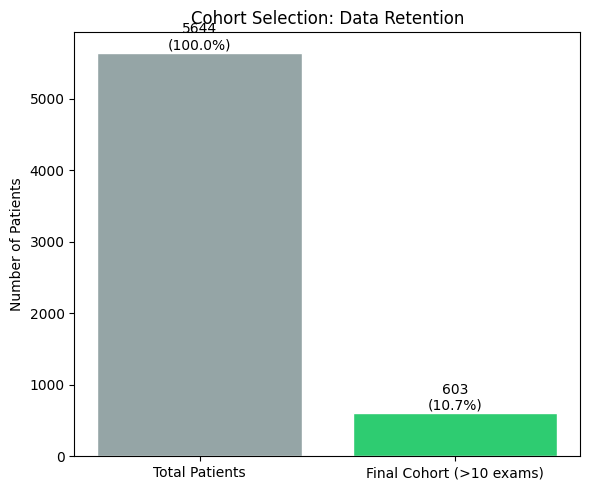

In [6]:
# 4. Cohort Selection: Data Retention
raw_df = pd.read_excel(DATA_PATH)
n_raw = len(raw_df)
n_final = len(df)
labels = ["Total Patients", "Final Cohort (>10 exams)"]
values = [n_raw, n_final]
colors = ["#95a5a6", "#2ecc71"]
pcts = [100.0, 100.0 * n_final / n_raw if n_raw > 0 else 0]

fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(labels, values, color=colors, edgecolor="white")
ax.set_title("Cohort Selection: Data Retention")
ax.set_ylabel("Number of Patients")
for bar, val, pct in zip(bars, values, pcts):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f"{val}\n({pct:.1f}%)", ha="center", va="bottom", fontsize=10)
plt.tight_layout()
plt.savefig(FIG_DIR / "cohort_selection_funnel.png", dpi=300)
plt.show()

### Interpretation: Cohort Selection and Data Retention
This chart reports the number of patients in the original raw file (Total Patients) and the number retained after applying the cohort selection rule that requires at least ten lab tests per patient. It quantifies how much of the cohort is removed for data quality reasons and clarifies what proportion of the original sample ultimately contributes to the downstream clinical and statistical analyses.

##  Summary

This preprocessing notebook converts a heterogeneous, partially observed raw cohort into a clean and analysis-ready dataset. We begin by loading the original Excel file, selecting patients and laboratory variables that meet minimal data availability requirements, and constructing a combined metadata–features table. Missing values in the laboratory measurements are then addressed using a KNN imputer, and distributions are regularized with a QuantileTransformer so that key biomarkers become more symmetric, less heavy-tailed and suitable for downstream PCA and clustering.

The diagnostic visualisations show that many raw variables have substantial missingness and highly skewed distributions, and they document how the preprocessing pipeline reduces sparsity and stabilises the marginal distributions without destroying clinically meaningful structure. The cohort retention plots further quantify how many patients are excluded in the interest of data quality. Together, these steps justify the use of `01_cleaned_advanced.csv` as a robust input for the phenotyping and validation analyses developed in Notebooks 02–04.